# Calculating DRT

This package estimates DRT by generating a Voigt circuit model and fitting its parameters using `LsqFit.jl`. The concept can be broken down simply: any impedance $Z(\omega)$ can be generated by a series of RC pairs:
$$
Z(\omega) = \sum_i^\infty \frac{R_i}{1+i\omega\tau_i},\\ \tau_i = R_iC_i
$$
This is analogous to a fourier transform for generic functions. Let's look at some examples.

In [1]:
using EISAnalysis

First, let's consider a simple circuit with 2 RC pairs

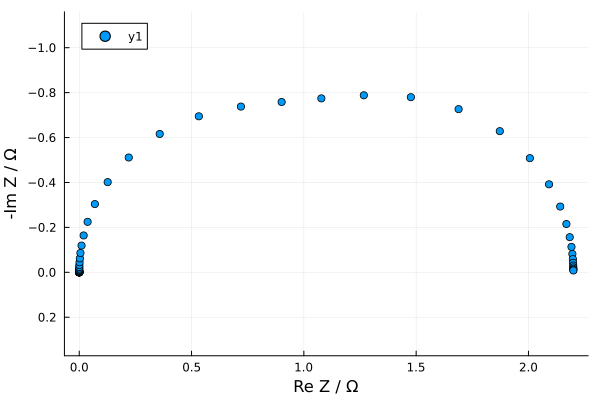

In [2]:
rc_circuit = r/c-1.2r/5c
plot_Nyquist(rc_circuit)

You can fit this to a Voigt circuit and estimate the DRT. The expanded fit includes the individual contribution from each RC pair in the Voigt circuit model and acts as a visual aid in interpreting the DRT plot.

rtol = 0.00010318757192544088


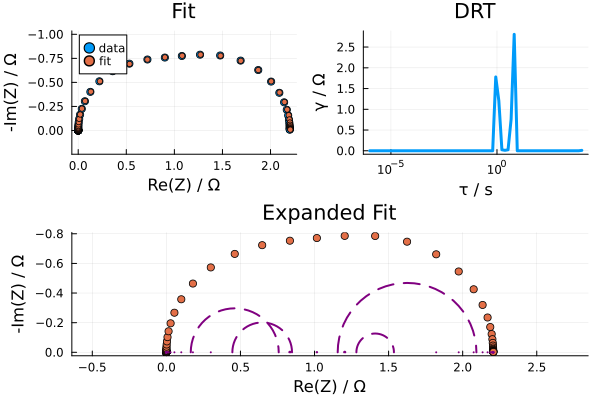

Dict{String, Any} with 4 entries:
  "Z"   => ComplexF64[1.08341e-10-1.21584e-5im, 2.09174e-10-1.6894e-5im, 4.0385…
  "τ"   => LogRange{Float64}(1.0e-6, 10000.0, 70)
  "R0"  => 0.0
  "drt" => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0,…

In [3]:
rc_fit = compute_drt(rc_circuit.ω,rc_circuit.Z;ppd=7,regularization=false)

Constant-phase elements are used to capture capacative (non-faradaic) processes which are non-ideal, and this is reflected in the gaussian shape of the DRT.

Regularization
--------------
λ = 1.0e-6
rtol = 7.273175407578912e-5


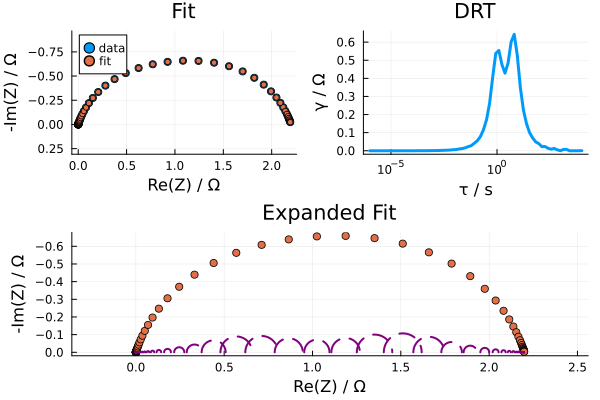

Dict{String, Any} with 4 entries:
  "Z"   => ComplexF64[4.25219e-5-0.000116054im, 5.29976e-5-0.000152715im, 6.676…
  "τ"   => LogRange{Float64}(1.0e-6, 10000.0, 70)
  "R0"  => 1.84548e-5
  "drt" => [0.0, 0.0, 0.0, 0.0, 4.02809e-6, 1.19968e-5, 2.05926e-5, 2.77464e-5,…

In [4]:
rq_circuit = r/q-1.2r/5q
rq_fit = compute_drt(rq_circuit.ω,rq_circuit.Z;regularization=true)

Now for more complicated circuits

Regularization
--------------
λ = 9.999999999999999e-5
rtol = 0.00034640886087762486


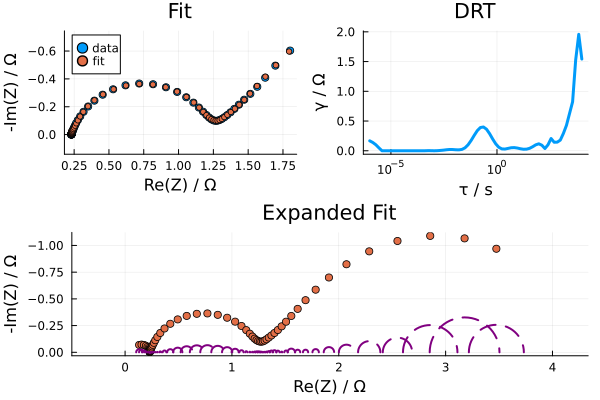

Dict{String, Any} with 4 entries:
  "Z"   => ComplexF64[0.227454-0.0224747im, 0.229245-0.0165243im, 0.2302-0.0121…
  "τ"   => LogRange{Float64}(1.0e-6, 10000.0, 70)
  "R0"  => 0.0790881
  "drt" => [0.167199, 0.13935, 0.100825, 0.0485843, 0.0, 0.0, 0.0, 0.0, 0.0, 0.…

In [5]:
randles_circuit = 0.23r-(r-0.025ws^80)/0.2q
randles_fit = compute_drt(randles_circuit.ω,randles_circuit.Z;regularization=true)

Now let's try to fit to experimental data. I found this dataset on Mendeley

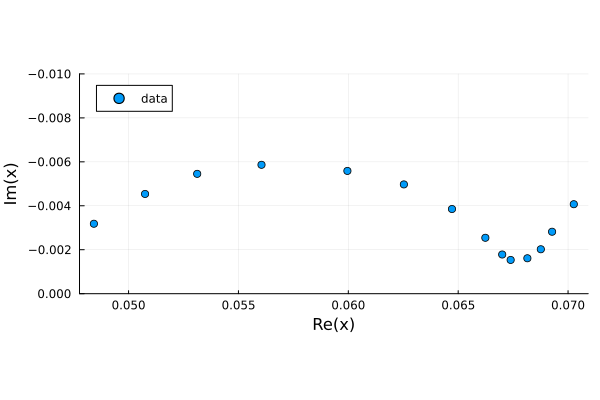

In [6]:
using CSV,DataFrames,Plots
ω_exp =  [ 0.05, 0.1, 0.2, 0.4, 1, 2, 4, 10, 20, 40, 100, 200, 400, 1000]
data = CSV.read("Data/EIS_Data.csv",DataFrame)
Z_exp = data[!,"Re(Z)"]-im*data[!,"-Im(Z)"]
plt =scatter(Z_exp,label = "data",aspect_ratio=:equal)
plot!(plt,ylims = (-0.01,0),yflip=true)

Regularization
--------------
λ = 0.01
rtol = 0.0009852302660567013


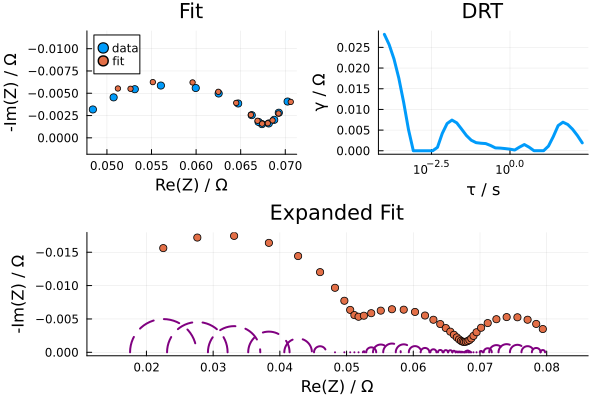

Dict{String, Any} with 4 entries:
  "Z"   => ComplexF64[0.0706146-0.00403033im, 0.0692473-0.00273329im, 0.0685726…
  "τ"   => LogRange{Float64}(0.0001, 200.0, 42)
  "R0"  => 0.0120707
  "drt" => [0.0281485, 0.0256443, 0.0221748, 0.0175302, 0.0116946, 0.00512165, …

In [9]:
fit = compute_drt(ω_exp,Z_exp;regularization=true)